# Indeed.com.au NLP

Finding out what factors most directly impact salaries (e.g. title, location, department, etc).

In [105]:
words = " "
cw = pd.DataFrame(word_counts.sort_values(ascending=False).head(200))
for word in cw.index:
    words += word+' '

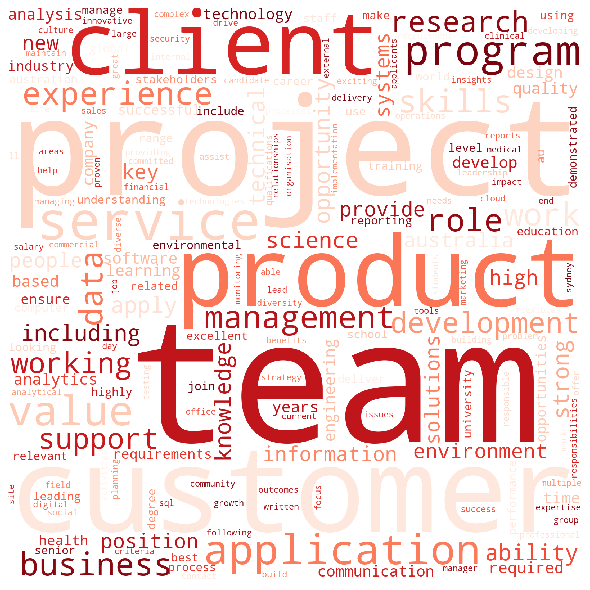

In [115]:
wordcloud = WordCloud(width=800, height=800,
                     background_color='white',
                     colormap='Reds',
                     scale=2,
                     min_font_size=8).generate_from_text(words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()
wordcloud.to_file('cloud.png')

In [5]:
import requests
from scrapy.selector import Selector
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

from wordcloud import WordCloud

from time import sleep, time
from random import randint

from scipy import sparse

from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error
import itertools
import math

import scikitplot as skplt

Importing the .csv

In [6]:
#import csv
df = pd.read_csv('./data_science.csv')

In [7]:
df.columns

Index(['Unnamed: 0', 'title', 'job_teaser', 'advertiser', 'work_type',
       'classification', 'location', 'job_description', 'estimated_salary',
       'above_ave_salary'],
      dtype='object')

In [8]:
df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
df.drop_duplicates('title', inplace=True)

Calculating the median salary and then converting roles to binary based on if they are higher or lower than the average.

In [10]:
median = df['estimated_salary'].median()
median

110000.0

What is our baseline? The value with the highest count.

In [11]:
df['above_ave_salary'].value_counts()

0    723
1    483
Name: above_ave_salary, dtype: int64

Our base value is..... 60%

In [12]:
(df['above_ave_salary'][df['above_ave_salary'] == 0].value_counts())/df['above_ave_salary'].shape[0]

0    0.599502
Name: above_ave_salary, dtype: float64

Checking distribution of salaries

NameError: name 'ax' is not defined

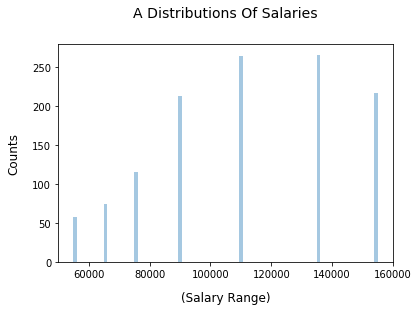

In [13]:
sns.distplot(df['estimated_salary'], bins = 90, kde=False)
plt.title('A Distributions Of Salaries', fontsize='14', pad=27)
plt.xlabel('(Salary Range)', fontsize='12', labelpad=12)
plt.ylabel('Counts', fontsize='12', labelpad=12)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.show()

## Model 1 : Features - Locations

Creating a copy of the df incase theres a disaster.

In [14]:
X_copy = df.copy()

In [15]:
X_copy.drop(columns=['advertiser', 'estimated_salary', 'job_teaser', 'classification', 'job_description'], inplace=True)
X = pd.get_dummies(data=X_copy, drop_first=True, columns=['location', 'title', 'work_type'])
y = X_copy.pop('above_ave_salary')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [17]:
models = [KNeighborsClassifier(n_jobs=-1),
          LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=1000, n_jobs=-1),
          ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)]

skf = StratifiedKFold(n_splits=5, shuffle=False)

for model in models:
    print(model)
    model.fit(X_train, y_train)
    print("The Cross Validation Score: ", np.mean(cross_val_score(model, X_train, y_train, cv=skf, n_jobs=-1)))
    y_pred = model.predict(X_test)
    print('---------')
    
    
models[1].fit(X_train, y_train)
model_1_coefficients_matrix = pd.DataFrame(np.abs(np.reshape(models[1].coef_, (-1, 1))), 
                                           index= X_train.columns, columns=['Log_Odds_Coefficients'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
The Cross Validation Score:  0.9979274611398964
---------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The Cross Validation Score:  1.0
---------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      

## Absolute Coefficients

In [18]:
X = df.copy()
X.drop(columns=['advertiser','estimated_salary', 'job_teaser', 'classification', 'job_description'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['location', 'title', 'work_type'])
y = X.pop('above_ave_salary')

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)


skf = StratifiedKFold(n_splits=5, shuffle=False)

lg = LogisticRegression(solver='lbfgs', multi_class='auto')
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

print("The Cross Validation Score", round(np.mean(cross_val_score(lg, X_train, y_train, cv=skf, verbose=0, )),3))
print("The Logistic Regression Accuracy Score", np.round(lg.score(X_test, y_test),3))

# Producing The Coefficients 

Logistic_Regression_Coefficients = lg.coef_

#Reshaping A Numpy Array + Setting Absolute Values For The Coefficients 
Logistic_Regression_Coefficients = np.abs(np.reshape(Logistic_Regression_Coefficients, (-1, 1)))


coefficients_matrix = pd.DataFrame(Logistic_Regression_Coefficients, index= X_train.columns, columns=['Log_Odds_Coefficients'])

The Cross Validation Score 0.591
The Logistic Regression Accuracy Score 0.599


In [19]:
coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(10)

,Log_Odds_Coefficients
"location_Kalgoorlie, Goldfields & Esperance",0.802168
"location_Port Hedland, Karratha & Pilbara",0.801807
location_Sydney,0.780654
title_Supply Chain Analyst,0.682726
location_Hobart,0.657925
"location_Newcastle, Maitland & Hunter",0.646119
title_Principal Analytics Consultant,0.632730
title_Technical Lead - Big data & Cloud,0.590689
title_Technical Governance Lead,0.590689
title_GIS Team Lead,0.590689


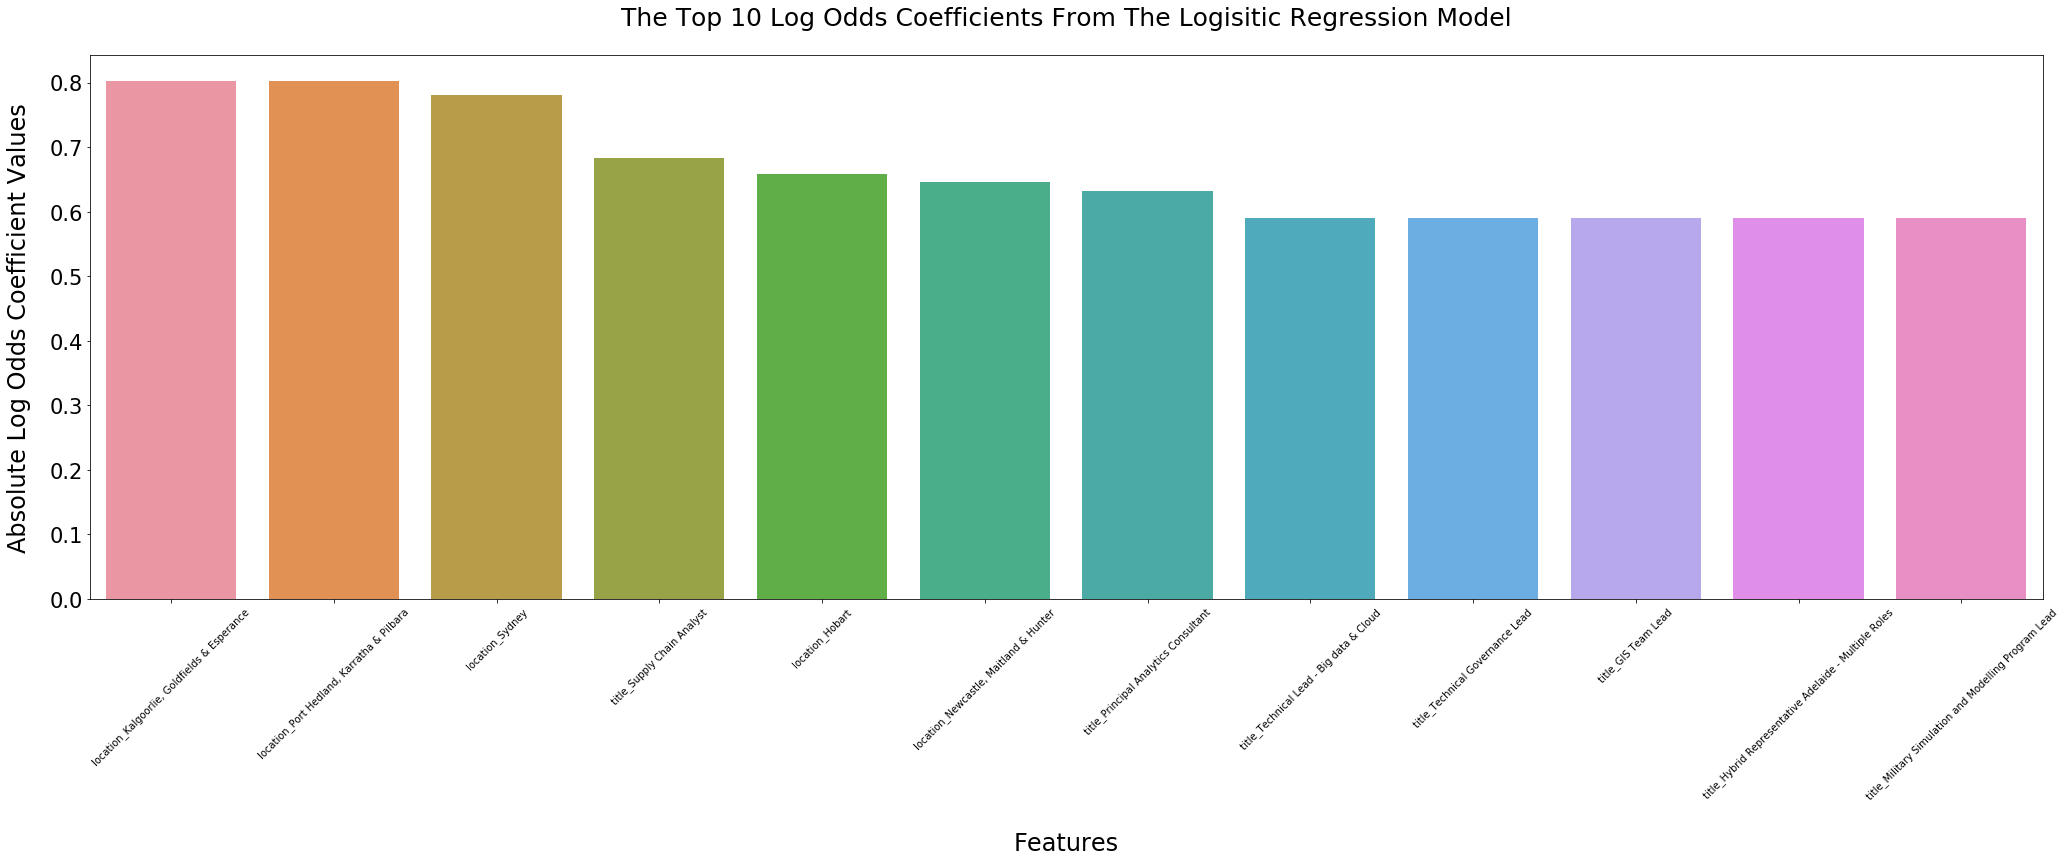

In [20]:
fig, ax = plt.subplots(figsize=(35,10))
sns.barplot(x=coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12).index,
            y= [float(item) for item in coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12).values])
plt.title('The Top 10 Log Odds Coefficients From The Logisitic Regression Model', pad=30, fontsize='25')
plt.xlabel('Features', fontsize='24', labelpad=30)
plt.ylabel('Absolute Log Odds Coefficient Values', fontsize='24', labelpad=18)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45)
ax.tick_params(axis='y', which='major', labelsize=21)

## Count Vectorising

In [21]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer(stop_words='english')

# Fitting the vectorizer on our training data
cvec.fit(df['job_description'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [22]:
# Transforming our x_train data using our fit cvec.
# And converting the result to a DataFrame.
X_train_vec = pd.DataFrame(cvec.transform(df['job_description']).todense(),
                       columns=cvec.get_feature_names())

In [23]:
# Which words appear the most?
word_counts = X_train_vec.sum(axis=0)
word_counts.sort_values(ascending = False).head(10)

data           4795
experience     4171
work           2899
team           2708
role           2440
skills         2362
business       2314
management     1873
development    1853
working        1810
dtype: int64

In [24]:
salary = df['above_ave_salary']

In [25]:
# What are we trying to predict
y_train_vec = df['estimated_salary']

In [26]:
# Lets look through some of the categories common words
common_words = []
for i in range(1):
    word_count = X_train_vec[y_train_vec==i].sum(axis=0)
    print("most common words")
    cw = word_count.sort_values(ascending = False).head(20)
    print(cw)
    common_words.extend(cw.index)
    print()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Term Frequency–Inverse Document Frequency [TFID]

In [27]:
df.columns

Index(['title', 'job_teaser', 'advertiser', 'work_type', 'classification',
       'location', 'job_description', 'estimated_salary', 'above_ave_salary'],
      dtype='object')

In [28]:
X = df.copy()
X = X.dropna(how='any')
X.drop(columns=['advertiser', 'job_teaser', 'classification', 'estimated_salary'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['location', 'title', 'work_type'])
y = X.pop('above_ave_salary')

In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

### TFID Vectorizer with Logistic Regression

In [30]:
model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5),
                      LogisticRegression(),
                      )
model.fit(X2_train['job_description'], y_train)
y_pred = model.predict(X2_test['job_description'])
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.7396694214876033
Number of features: 16954


### Hashing Vectorizer with Logistic Regression

In [31]:
model = make_pipeline(HashingVectorizer(stop_words='english'),
                                      LogisticRegression(),
                                      )
model.fit(X2_train['job_description'], y_train)
y_pred = model.predict(X2_test['job_description'])
print(accuracy_score(y_test, y_pred))
print("Number of features:", 2**16)

0.7603305785123967
Number of features: 65536


### TFID Vectorizer with 6 different Classifiers

In [32]:
TFID = TfidfVectorizer(stop_words='english',
                      sublinear_tf=True,
                      max_df=0.5)

X2_train_tfid = TFID.fit_transform(X2_train['job_description'])
X2_test_tfid = TFID.transform(X2_test['job_description'])

X2_train.drop(columns=['job_description'], inplace=True)
X2_test.drop(columns=['job_description'], inplace=True)

X_Train_Sparse = sparse.csr_matrix(X2_train.values)
X_Test_Sparse = sparse.csr_matrix(X2_test.values)

y2_train.reset_index(drop=True)
y2_test.reset_index(drop=True)

X2_train = sparse.hstack((X2_train_tfid, X_Train_Sparse))
X2_test = sparse.hstack((X2_test_tfid, X_Test_Sparse))

models = [KNeighborsClassifier(n_jobs=-1),
          LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100, n_jobs=-1),
          ExtraTreesClassifier(n_estimators=100, n_jobs=-1)]

for model in models:
    print(model)
    model.fit(X2_train, y2_train)
    score = round(model.score(X2_test, y2_test),2)
    print("The Cross Validation Score: ", round(np.mean(cross_val_score(model, X2_train, y2_train, cv=skf, n_jobs=-1)),2))
    print('Accuracy Score On X_test Data', score)
    print('---------')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
The Cross Validation Score:  0.67
Accuracy Score On X_test Data 0.71
---------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The Cross Validation Score:  0.71
Accuracy Score On X_test Data 0.74
---------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fracti

## Confusion Matrix

In [33]:
y2_test.value_counts()

0    145
1     97
Name: above_ave_salary, dtype: int64

In [34]:
lg = LogisticRegression(solver='lbfgs', multi_class='auto')
lg.fit(X2_train, y2_train)
predictions = lg.predict(X2_test)

In [35]:
CM = confusion_matrix(y2_test, predictions, labels=[1, 0])
CM

array([[ 55,  42],
       [ 22, 123]])

In [36]:
tn, fp, fn, tp = confusion_matrix(y2_test, predictions).ravel()
(tn, fp, fn, tp)

(123, 22, 42, 55)

In [37]:
confusion_matrix_df = pd.DataFrame(CM, columns=['High_Salary_Class', 'Low_Salary_Class'], 
                                   index=['It Is A High Salary Job','It Is A Low Salary Job'])

confusion_matrix_df

,High_Salary_Class,Low_Salary_Class
It Is A High Salary Job,55,42
It Is A Low Salary Job,22,123


In [38]:
probabilities = lg.predict_proba(X2_test)
len(probabilities)

242

## ROC Curve

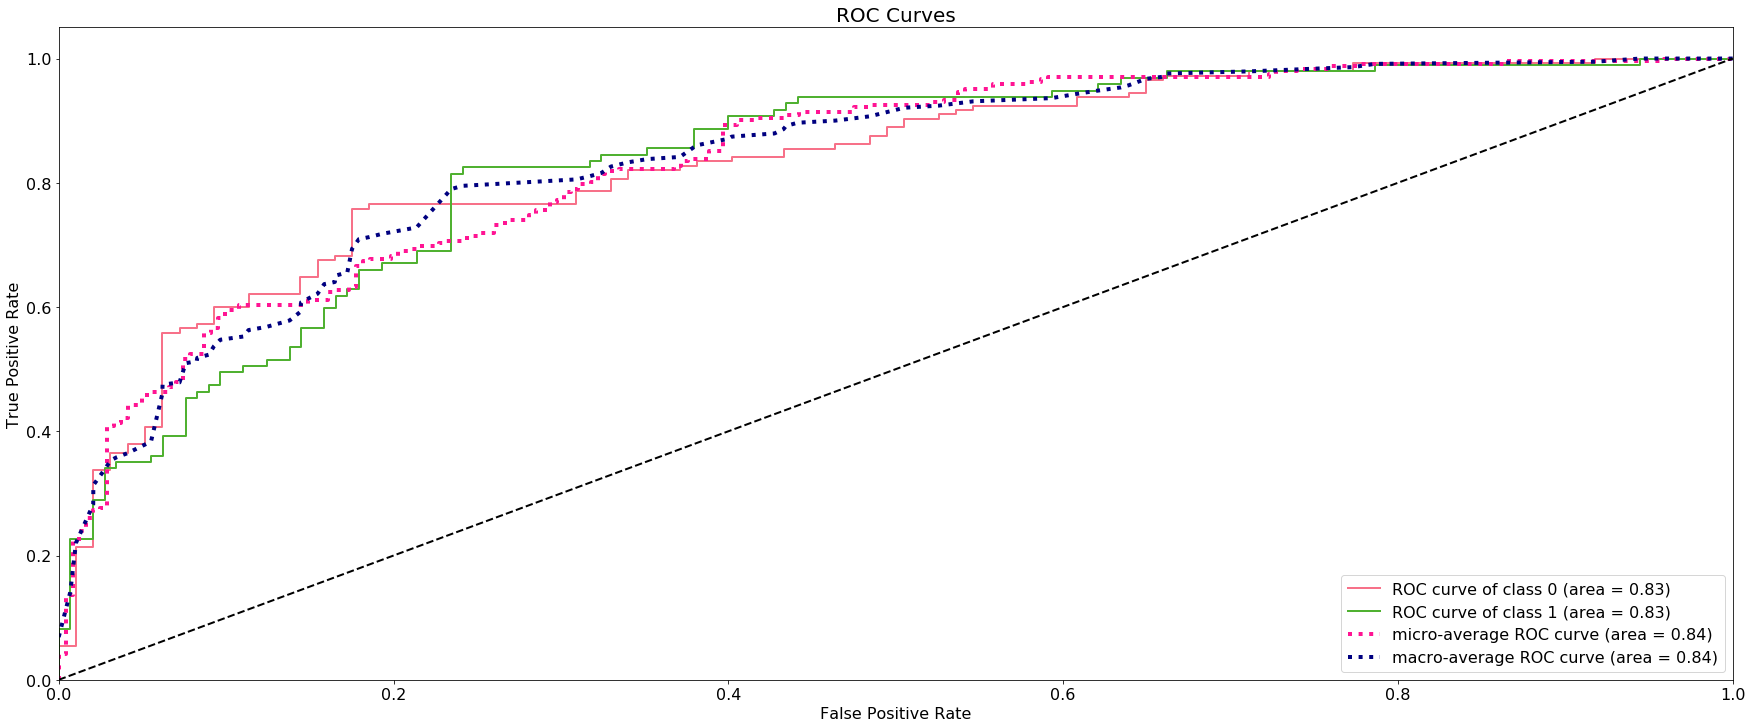

In [39]:
cmap = ListedColormap(sns.color_palette("husl",3))

skplt.metrics.plot_roc(y2_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(30,12), cmap=cmap)
plt.show()

The ROC Curve has been plotted for both above average and below average salaries. 

We can see that the logistic regression model is outperforming the baseline of ~60%. Meaning that as we increase the threshold to remove false positives, we will acquire less false negatives in relation to how many false positives we loose.

A true positive score of 1.0 indicates that we would never misidentify a class using the predictors chosen in this model.